In [1]:
import numpy as np
import matplotlib.pyplot as plt

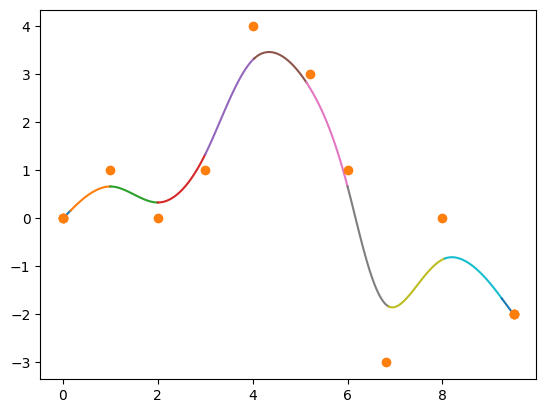

In [19]:
#create the basis coefficient matrices
#spline types: Bezier, BSpline, Catmull-Rom
#create a json file to store the basis matrices for each of the above splines

#original minvo from the paper which works for t values of -1  to 1
minvo3 = np.array([
    [-0.4302, 0.4568, -0.02698, 0.0004103],
    [0.8349, -0.4568, -0.7921, 0.4997],
    [-0.8349, -0.4568, 0.7921, 0.4996],
    [0.4302, 0.4568, 0.02698, -0.0004103]
]).T

#modified minvo to work with t from 0 to 1 like most other splines
minvo3 = np.array([
    [-3.4416, 6.9896, -4.46236, 0.91439], 
    [6.6792, -11.846, 5.2524, 0.0001],
    [-6.6792, 8.1916, -1.598, 0.0856],
    [3.4416, -3.3352, 0.80796, -0.0007903]
]).T

# t = -1
# print(np.array([t**3, t**2, t, 1])@minvo3)
# t = 0
# print(np.array([t**3, t**2, t, 1])@minvo3_1)
bezier3 = np.array([
    [-1, 3, -3, 1],
    [3, -6, 3, 0], 
    [-3, 3, 0, 0],
    [1, 0, 0, 0]])

bspline3 = np.array([
    [-1, 3, -3, 1],
    [3, -6, 3, 0],
    [-3, 0, 3, 0],
    [1, 4, 1, 0]]) / 6

#random four points in space
points = np.array([[0,0],[0,0],[0,0],[1,1], [2,0],[3,1], [4,4], [5.2,3], [6,1],[6.8,-3], [8,0], [9.5,-2],[9.5,-2],[9.5,-2]])
# points = np. array([[3,1],[3,1],[3,1],[8,-2]])

def draw_spline(t:float, points:np.ndarray):
    # print(t)
    T = np.array([t**3, t**2, t, 1])
    MP = bspline3@points
    P = T@MP
    return P
# print(points[:-1].shape, points[:-1])
t_values = np.linspace(0, 1, 100)
for i in range(len(points)-3):
    spline_points = np.array([draw_spline(t, points[i:i+4]) for t in t_values])
    plt.plot(spline_points[:,0], spline_points[:,1])

#convert between spline control points
# minvo_points = np.linalg.inv(minvo3)@bspline3@points
# plt.plot(minvo_points[:, 0], minvo_points[:, 1], 'o')
plt.plot(points[:, 0], points[:, 1], 'o')


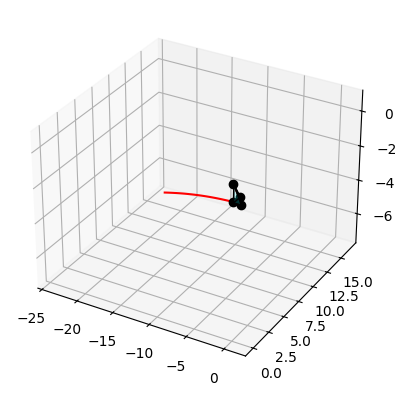

In [20]:
#create the basis coefficient matrices
#spline types: Bezier, BSpline, Catmull-Rom
#create a json file to store the basis matrices for each of the above splines
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#random four points in space
points = np.array([[0,0,0], [1,0,0], [0,1,0], [0,0,1]])

def draw_spline(t:float):
    # print(t)
    T = np.array([t**3, t**2, t, 1])
    MP = minvo3@points
    P = T@MP
    return P

t_values = np.linspace(-1, 1, 100)
spline_points = np.array([draw_spline(t) for t in t_values])
hull = ConvexHull(points)
ax = plt.figure().add_subplot(projection='3d')
for simplex in hull.simplices:
    # Extract the vertices for each simplex (face of the tetrahedron)
    simplex = np.append(simplex, simplex[0])  # loop back to first vertex
    # Fill the face with a translucent color
    triangle = points[simplex[:3]]
    ax.add_collection3d(Poly3DCollection([triangle], ec = 'k', fc='cyan', alpha=0.1))  # adjust alpha for translucency
ax.plot(spline_points[:,0], spline_points[:,1],spline_points[:,2], color = 'r')
ax.plot(points[:, 0], points[:, 1], points[:, 2], 'ko')
plt.show()

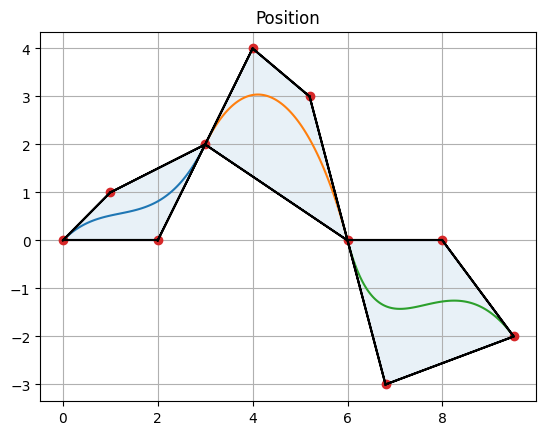

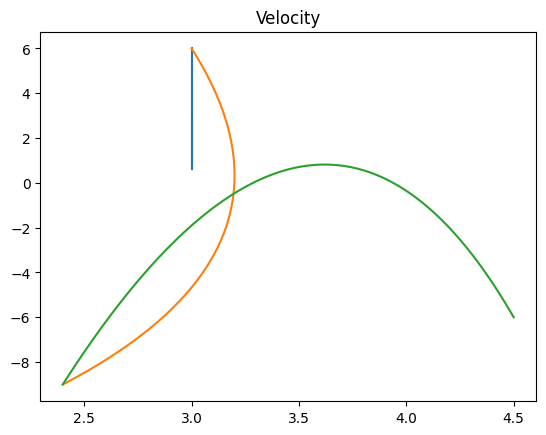

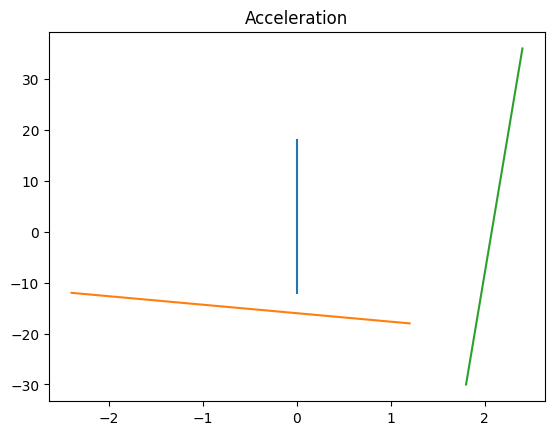

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike
from typing import Literal
from scipy.spatial import ConvexHull
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots()
basis = minvo3

def polynomial_matrix(t_values, max_degree):
    # Create an array from t^max_degree to t^1, and include an array of 1s for t^0
    return np.vstack([t_values**i for i in range(max_degree, -1, -1)]).T

def derivative_matrix(poly_matrix):
    # Get the number of columns (max_degree + 1)
    max_degree = poly_matrix.shape[1] - 1
    # Create the derivative matrix
    derivatives = np.zeros_like(poly_matrix)
    for i in range(max_degree):
        # Derivative of t^degree is degree*t^(degree-1)
        degree = max_degree - i
        derivatives[:, i] = degree * poly_matrix[:, i+1]
    # The last column (constant term) derivative is zero and already initialized
    return derivatives


# Assuming the points array is extended to multiple segments
def draw_connected_splines(points, basis:str):
    num_segments = (len(points) - 1) // 3
    if basis in {'bernstein', 'bezier'}:
        basis = bezier3
    elif basis == 'bspline':
        basis = bspline3
    else:
        basis = minvo3
    t_values = np.linspace(0, 1, 100)
    all_spline_points = []
    all_velocity_points = []
    all_acceleration_points = []
    hulls = []
    for i in range(num_segments):
        segment_points = points[3*i:3*i+4]  # Select the 4 control points for the current segment
        # print(segment_points)
        T = polynomial_matrix(t_values, max_degree= basis.shape[0] - 1)
        spline_points = T@basis@segment_points
        Tvel = derivative_matrix(T)
        velocity_points = Tvel@basis@segment_points
        Tacc = derivative_matrix(Tvel)
        acceleration_points = Tacc@basis@segment_points
        all_spline_points.append(spline_points)
        all_velocity_points.append(velocity_points)
        all_acceleration_points.append(acceleration_points)
        # print(f"{segment_points =}")
        hulls.append(ConvexHull(segment_points))
        # print(segment_points)
        

    for spline_points in all_spline_points:
        plt.plot(spline_points[:, 0], spline_points[:, 1])

    plt.plot(points[:, 0], points[:, 1], 'o')  # Plot all control points

    for idx, hull in enumerate(hulls):
        n = (hull.vertices.shape[0]-1)
        for simplex in hull.simplices:
            # Loop back to the first vertex to close the polygon
            simplex = np.append(simplex, simplex[0])+idx*n
            # print(f"{simplex=}")
            ax.plot(points[simplex, 0], points[simplex, 1], 'k-')  # Black edge color

            # Fill the polygon with a translucent color
            # verts = np.array([[0,0], [1,0],[1,1]])
            # print(hull.vertices, "hi")
        polygon = plt.Polygon(points[hull.vertices+idx*n], closed=True, alpha=0.1, edgecolor='magenta')
        # print(type(points[simplex]),points[simplex], polygon.get_verts())
        ax.add_patch(polygon)
            # print(ax.patches)

    plt.grid(True)
    plt.title('Position')
    plt.show()

    for velocity_points in all_velocity_points:
        plt.plot(velocity_points[:, 0], velocity_points[:, 1])
    # V = 
    plt.title('Velocity')
    plt.show()

    for acceleration_points in all_acceleration_points:
        plt.plot(acceleration_points[:, 0], acceleration_points[:, 1])
    plt.title('Acceleration')
    plt.show()
# Example control points
points = np.array([[0,0],[0,0],[0,0],[0,0], [1.2,1], [2,0], [3,2],[3,2],[3,2],[3,2], [4,4], [5.2,3], [6,0],[6.8,-3], [8,0], [9.5,-2],[11,-4],[11.5,2],[12.1,-2]])
points = np.array([[0,0],[1,1], [2,0],[3,2], [4,4], [5.2,3], [6,0],[6.8,-3], [8,0], [9.5,-2]])
# points = np.array([[3,2], [4,4], [5.2,3], [6,0]])

draw_connected_splines(points, 'bernstein')




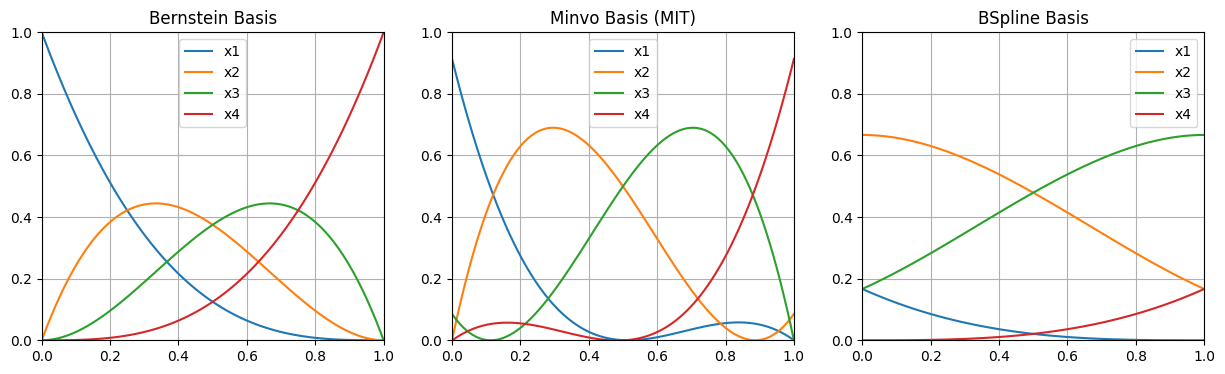

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))  # 10 inches wide, 4 inches tall

# First plot
ts = np.linspace(0, 1, 100)
T = polynomial_matrix(ts, 3)
ys = T @ bezier3

plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(ts, ys)
plt.grid(True)
plt.legend(['x1', 'x2', 'x3', 'x4'])
plt.title('Bernstein Basis')
plt.ylim(0,1)
plt.xlim(0,1)


# Second plot
ts = np.linspace(0, 1, 100)
T = polynomial_matrix(ts, 3)
ys = T @ minvo3

plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(ts, ys)
plt.grid(True)
plt.legend(['x1', 'x2', 'x3', 'x4'])
plt.title('Minvo Basis (MIT)')
plt.ylim(0,1)
plt.xlim(0,1)


# Second plot
ts = np.linspace(0, 1, 100)
T = polynomial_matrix(ts, 3)
ys = T @ bspline3

plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
plt.plot(ts, ys)
plt.grid(True)
plt.legend(['x1', 'x2', 'x3', 'x4'])
plt.title('BSpline Basis')
plt.ylim(0,1)
plt.xlim(0,1)


# Show the plots
plt.show()

In [6]:
from numpy.typing import ArrayLike
def create_t_matrix(t_values:ArrayLike, max_degree:int):
    # Create an array from t^max_degree to t^1, and include an array of 1s for t^0
    terms = [np.array(t_values)**i for i in range(max_degree, -1, -1)]
    return np.vstack(terms).T

create_t_matrix(np.array([1,2,3]), 3)

array([[ 1,  1,  1,  1],
       [ 8,  4,  2,  1],
       [27,  9,  3,  1]])

In [7]:
import numpy as np

def polynomial_matrix(t_values, max_degree):
    # Create an array from t^max_degree to t^1, and include an array of 1s for t^0
    return np.vstack([t_values**i for i in range(max_degree, -1, -1)]).T

def derivative_matrix(poly_matrix):
    # Get the number of columns (max_degree + 1)
    max_degree = poly_matrix.shape[1] - 1
    # Create the derivative matrix
    derivatives = np.zeros_like(poly_matrix)
    for i in range(max_degree):
        print(f"{i=}")
        # Derivative of t^degree is degree*t^(degree-1)
        degree = max_degree - i
        print(f"{degree=}")
        derivatives[:, i] = degree * poly_matrix[:, i+1]
    # The last column (constant term) derivative is zero and already initialized
    return derivatives

# Example usage:
t_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
max_degree = 3
poly_mat = polynomial_matrix(t_values, max_degree)
deriv_mat = derivative_matrix(poly_mat)

print("Polynomial Matrix:\n", poly_mat)
print("Derivative Matrix:\n", deriv_mat)


i=0
degree=3
i=1
degree=2
i=2
degree=1
Polynomial Matrix:
 [[   1    1    1    1]
 [   8    4    2    1]
 [  27    9    3    1]
 [  64   16    4    1]
 [ 125   25    5    1]
 [ 216   36    6    1]
 [ 343   49    7    1]
 [ 512   64    8    1]
 [ 729   81    9    1]
 [1000  100   10    1]]
Derivative Matrix:
 [[  3   2   1   0]
 [ 12   4   1   0]
 [ 27   6   1   0]
 [ 48   8   1   0]
 [ 75  10   1   0]
 [108  12   1   0]
 [147  14   1   0]
 [192  16   1   0]
 [243  18   1   0]
 [300  20   1   0]]


In [8]:
import numpy as np

def polynomial_matrix(t_values, max_degree):
    # Generate a matrix of powers of t from t^max_degree to t^0
    return np.vstack([t_values**i for i in range(max_degree, -1, -1)]).T

def nth_derivative_matrix(poly_matrix, n):
    num_rows, num_cols = poly_matrix.shape
    derivatives = poly_matrix.copy()
    for _ in range(n):
        # Prepare a new matrix to store the next derivative
        new_derivatives = np.zeros_like(derivatives)
        for col in range(num_cols - 1):  # Last column is always zero after differentiation
            # The new column is the current column index multiplied by the next column in the derivative matrix
            new_derivatives[:, col] = (num_cols - col - 1) * derivatives[:, col + 1]
        # Update derivatives matrix
        derivatives = new_derivatives
    return derivatives

# Example usage:
t_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
max_degree = 3
n = 2  # Change this for different nth derivatives
poly_mat = polynomial_matrix(t_values, max_degree)
nth_deriv_mat = nth_derivative_matrix(poly_mat, n)

print("Polynomial Matrix:\n", poly_mat)
print(f"{n}th Derivative Matrix:\n", nth_deriv_mat)


Polynomial Matrix:
 [[   1    1    1    1]
 [   8    4    2    1]
 [  27    9    3    1]
 [  64   16    4    1]
 [ 125   25    5    1]
 [ 216   36    6    1]
 [ 343   49    7    1]
 [ 512   64    8    1]
 [ 729   81    9    1]
 [1000  100   10    1]]
2th Derivative Matrix:
 [[ 6  2  0  0]
 [12  2  0  0]
 [18  2  0  0]
 [24  2  0  0]
 [30  2  0  0]
 [36  2  0  0]
 [42  2  0  0]
 [48  2  0  0]
 [54  2  0  0]
 [60  2  0  0]]


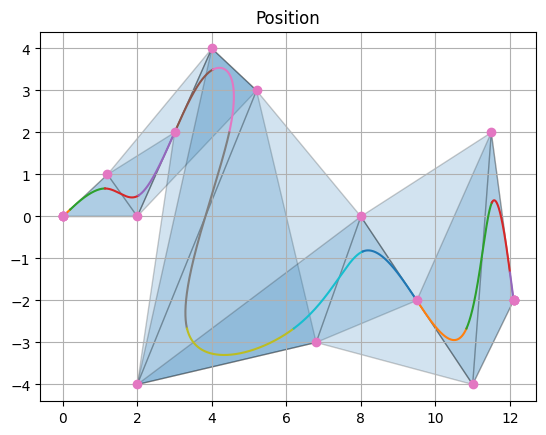

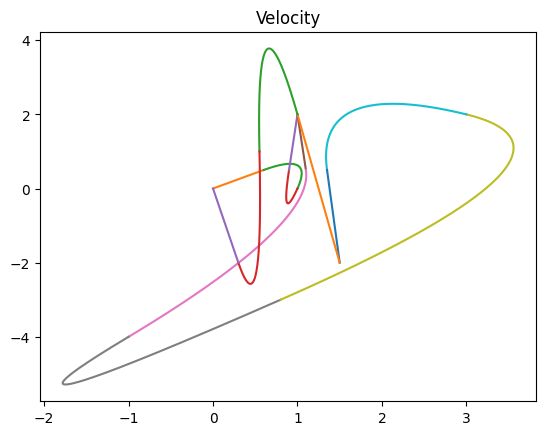

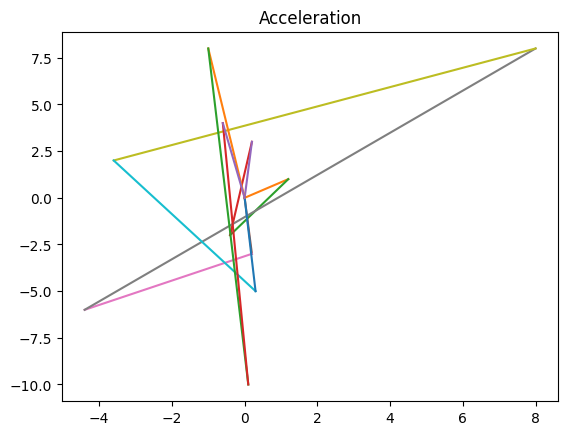

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike
from typing import Literal
from scipy.spatial import ConvexHull
from matplotlib.collections import PolyCollection
import random

fig, ax = plt.subplots()
basis = minvo3

def polynomial_matrix(t_values, max_degree):
    # Create an array from t^max_degree to t^1, and include an array of 1s for t^0
    return np.vstack([t_values**i for i in range(max_degree, -1, -1)]).T

def derivative_matrix(poly_matrix):
    # Get the number of columns (max_degree + 1)
    max_degree = poly_matrix.shape[1] - 1
    # Create the derivative matrix
    derivatives = np.zeros_like(poly_matrix)
    for i in range(max_degree):
        # Derivative of t^degree is degree*t^(degree-1)
        degree = max_degree - i
        derivatives[:, i] = degree * poly_matrix[:, i+1]
    # The last column (constant term) derivative is zero and already initialized
    return derivatives


# Assuming the points array is extended to multiple segments
def draw_connected_splines(points, basis:str):
    num_segments = (len(points) - 1) // 3
    if basis in {'bernstein', 'bezier'}:
        basis = bezier3
    elif basis == 'bspline':
        basis = bspline3
    else:
        basis = minvo3
    t_values = np.linspace(0, 1, 1000)
    all_spline_points = []
    all_velocity_points = []
    all_acceleration_points = []
    hulls = {}
    for i in range(len(points)-3):
        segment_points = points[i:i+4]  # Select the 4 control points for the current segment
        # print(segment_points)
        T = polynomial_matrix(t_values, max_degree= basis.shape[0] - 1)
        spline_points = T@basis@segment_points
        Tvel = derivative_matrix(T)
        velocity_points = Tvel@basis@segment_points
        Tacc = derivative_matrix(Tvel)
        acceleration_points = Tacc@basis@segment_points
        all_spline_points.append(spline_points)
        all_velocity_points.append(velocity_points)
        all_acceleration_points.append(acceleration_points)
        # print(f"{segment_points =}")
        try:
            hulls[i] = ConvexHull(segment_points)
        except Exception:
            pass
        # print(segment_points)
        

    for spline_points in all_spline_points:
        plt.plot(spline_points[:, 0], spline_points[:, 1])

    plt.plot(points[:, 0], points[:, 1], 'o')  # Plot all control points

    for i, hull in hulls.items():
        n = (hull.vertices.shape[0]-1)
        for simplex in hull.simplices:
            # Loop back to the first vertex to close the polygon
            simplex = np.append(simplex, simplex[0])+i
            # print(simplex)
            # print(f"{simplex=}")
            # ax.plot(points[simplex, 0], points[simplex, 1], 'k-')  # Black edge color

            # Fill the polygon with a translucent color
            # verts = np.array([[0,0], [1,0],[1,1]])
            # print(hull.vertices, "hi")
        polygon = plt.Polygon(points[hull.vertices+i], closed=True, alpha=0.2, edgecolor=(0,0,0,1))#, fc = random.choice(['k','r','b','magenta','y']))
        # print(type(points[simplex]),points[simplex], polygon.get_verts())
        ax.add_patch(polygon)
            # print(ax.patches)

    plt.grid(True)
    plt.title('Position')
    plt.show()

    for velocity_points in all_velocity_points:
        plt.plot(velocity_points[:, 0], velocity_points[:, 1])
    # V = 
    plt.title('Velocity')
    plt.show()

    for acceleration_points in all_acceleration_points:
        plt.plot(acceleration_points[:, 0], acceleration_points[:, 1])
    plt.title('Acceleration')
    plt.show()
# Example control points

control_points = np.array([[0,0], [1.2,1], [2,0], [3,2], [4,4], [5.2,3], [2,-4],[6.8,-3], [8,0], [9.5,-2],[11,-4],[11.5,2],[12.1,-2]])
# control_points = np.array([[0,0], [1.2,1], [2,0],[3,2],[4,0]])
knots = np.array([0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 12, 12])
# knots = np.array([0,0,0,1,2,3,3,3])
#create points from control points and knots
points = control_points[knots]
# print(points)

# points = np.array([[0,0],[1,1], [2,0],[3,2], [4,4], [5.2,3], [6,0],[6.8,-3], [8,0], [9.5,-2]])
# points = np.array([[3,2], [4,4], [5.2,3], [6,0]])

draw_connected_splines(points, 'bspline')




In [10]:
from scipy.optimize import minimize

def calculate_effort(points):
    jerk_matrix = np.array([[6,0,0,0]])
    jerk = jerk_matrix@bspline3@points
    return np.linalg.norm(jerk)**2



# Objective function: sum of squares of the equations
def objective(control_points):
    points = np.array(control_points).reshape((4,-1))
    effort = calculate_effort(points)
    # Your equations here, corrected to return the sum of squares
    return effort
# Bounds for mu, sigma, and tf
bounds = ((3, 8), (5, 7), (0, 10), (0, 10),(0, 10), (0, 10),(0, 10), (0, 10))

# Initial guess
# initial_guess = [1, 0, 1]
initial_guess = [0,0,0,1,1,1,1,0] #x1y1x2y2x3y3x4y4
# Minimization with SLSQP
result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds)
print(result)
# Check the result
if result.success:
    print(f"Found solution: result.x = {result.x}")
    points = result.x.reshape(4,-1)
    points = np.vstack((points[0],points[0],points,points[-1],points[-1]))
    print(points)
else:
    print("Failed to find a solution:", result.message)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.7433020818270714e-14
       x: [ 3.006e+00  5.000e+00  1.201e+00  2.117e+00  8.964e-01
            8.588e-01  2.091e+00  1.226e+00]
     nit: 3
     jac: [-2.256e-07 -2.129e-07  8.555e-07  8.176e-07 -5.873e-07
           -5.494e-07  2.554e-07  2.427e-07]
    nfev: 30
    njev: 3
Found solution: result.x = [3.00610538 5.         1.20123331 2.11682645 0.89636119 0.85881311
 2.09148912 1.2259601 ]
[[3.00610538 5.        ]
 [3.00610538 5.        ]
 [3.00610538 5.        ]
 [1.20123331 2.11682645]
 [0.89636119 0.85881311]
 [2.09148912 1.2259601 ]
 [2.09148912 1.2259601 ]
 [2.09148912 1.2259601 ]]
